In [181]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/src/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from data.make_dataset import ESDCData
from features.dependence import GetXYData
from models.dependence import HSICDependence
from visualization.dependence import plot_raw_variables, plot_sens_mod, plot_sens_angle, plot_sens_scatters
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df
from kernellib.dependence import HSIC, RHSIC

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('ggplot')
import cartopy
import cartopy.crs as ccrs
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract Data

In [2]:
year = '2011'

In [38]:
xr_dataset = xr.merge([
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/root_moisture/*e.nc'),
    xr.open_mfdataset('/media/disk/databases/BACI-CABLAB/low_res_data/gross_primary_productivity/*.nc')]
)



# Extract summertime months
xr_dataset = xr_dataset.sel(time=slice(str(2009), str(2011)))

# Extract russian, european region
xr_dataset_r = xr_dataset.sel(lat = slice(60.,50.), lon = slice(30.,60.))
xr_dataset = xr_dataset.sel(lat = slice(70.,30.), lon = slice(-20.,35.))


# extract dates
dates = xr_dataset.time.data


In [40]:
xr_dataset

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 160, lon: 220, time: 138)
Coordinates:
  * lon                         (lon) float32 -19.875 -19.625 ... 34.625 34.875
  * lat                         (lat) float32 69.875 69.625 ... 30.375 30.125
  * time                        (time) datetime64[ns] 2009-01-05 ... 2011-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(138, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(138, 220, 2), chunksize=(46, 220, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(138, 160, 2), chunksize=(46, 160, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 160, 220), chunksize=(46, 160, 220)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 160, 220), chunksize=(46, 160, 220)>

In [41]:
xr_dataset_r

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 40, lon: 120, time: 138)
Coordinates:
  * lon                         (lon) float32 30.125 30.375 ... 59.625 59.875
  * lat                         (lat) float32 59.875 59.625 ... 50.375 50.125
  * time                        (time) datetime64[ns] 2009-01-05 ... 2011-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                   (time, bnds) datetime64[ns] dask.array<shape=(138, 2), chunksize=(46, 2)>
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(138, 120, 2), chunksize=(46, 120, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(138, 40, 2), chunksize=(46, 40, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 40, 120), chunksize=(46, 40, 120)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 40, 120), chunksize=(46, 40, 120)>

### Plot Raw Variables

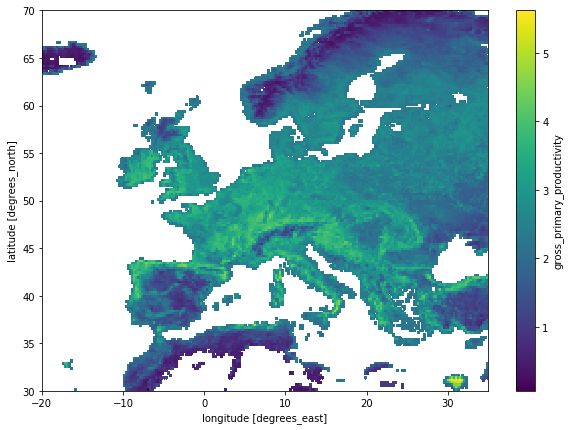

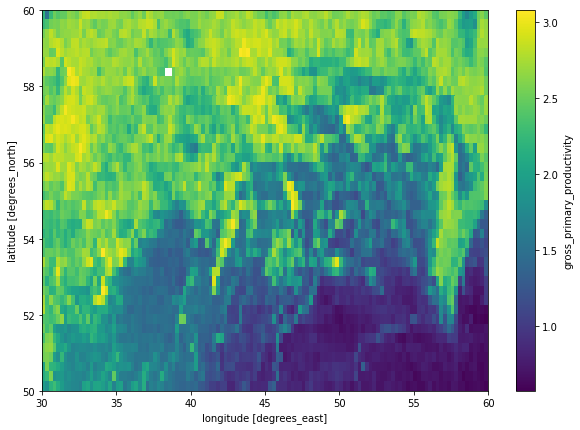

In [43]:
fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset['gross_primary_productivity'].mean(dim='time').plot.pcolormesh(ax=ax)

plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset_r['gross_primary_productivity'].mean(dim='time').plot.pcolormesh(ax=ax)

plt.show()

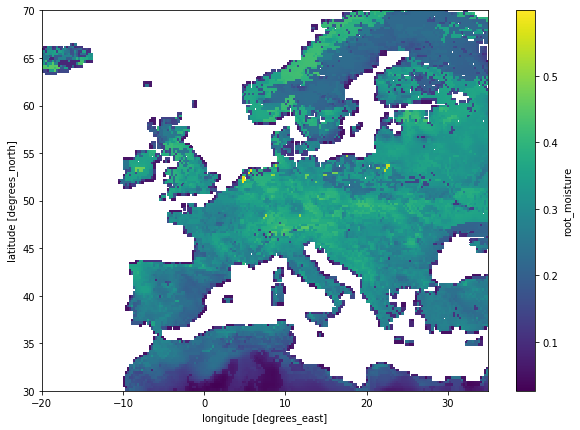

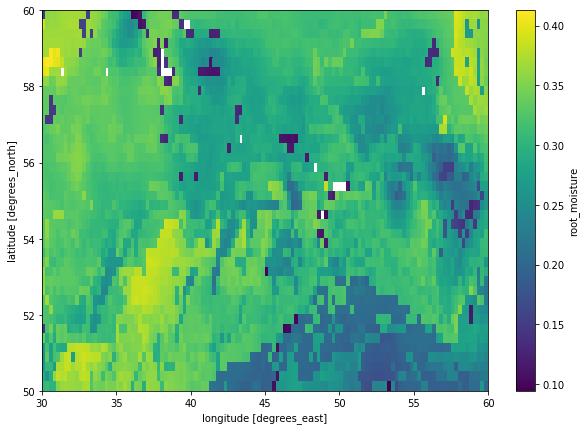

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset['root_moisture'].mean(dim='time').plot.pcolormesh(ax=ax)

plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

xr_dataset_r['root_moisture'].mean(dim='time').plot.pcolormesh(ax=ax)

plt.show()

### Conversion: Pandas DataFrame & Xarray Dataset

In [7]:
# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

In [8]:
# convert xarray to df
def create_df(xr_array, variable='gross_primary_productivity'):
    """Function to convert an xarray into a dataframe.
    This also preserves the lat and lon coordinates."""
    # Subset
    try:
        xr_df = xr_array.where(xr_array.mask==1).mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
        # drop mask
        xr_df = xr_df.drop('mask', 1)
    except AttributeError:
        xr_df = xr_array.mean(dim='time', skipna=True)[variable].to_dataframe(variable).dropna()
    except:
        pass
    
    
    # Remove duplicates
    xr_df = xr_df.reset_index().pivot_table(
        index=range(xr_df.shape[0]),
        values=[variable, 'lat', 'lon']
    ).drop_duplicates()
    
    return xr_df

# Convert df to xarray
def create_xarray(xr_df, variable='gross_primary_productivity'):
    
    xr_df = xr_df.reset_index().pivot_table(index=['lat', 'lon'], values=variable)
    
    return xr_df.to_xarray()

#### Convert XARRAY to DATAFRAME

In [9]:
variable = 'gross_primary_productivity'

gpp_df = create_df(xr_dataset, variable)

gpp_df.head()

gross_primary_productivity     lat     lon
0                    2.314191  69.875  18.125
1                    2.244336  69.875  18.375
2                    2.246074  69.875  18.625
3                    1.192227  69.875  18.875
4                    1.226036  69.875  19.125

#### Convert DATAFRAME to XARRAY

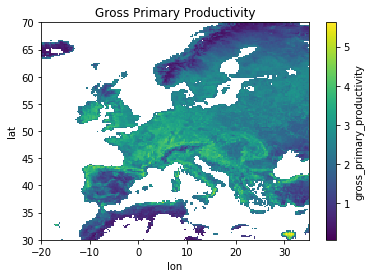

In [10]:
gpp_xr = create_xarray(gpp_df, variable)

fig, ax = plt.subplots()

gpp_xr[variable].plot.imshow(ax=ax, cmap='viridis', robust=False)
ax.set_title('Gross Primary Productivity')
plt.show()

In [11]:
gpp_df = create_df(xr_dataset, variable='gross_primary_productivity')
sm_df = create_df(subset, variable='soil_moisture')

var_df = gpp_df.merge(sm_df)
var_df = var_df.dropna()



NameError: name 'subset' is not defined

In [17]:
print(X.shape)

(23770,)


## Preliminary Data Exploration

### Extract Data with time as dimension

In [57]:
derX, derY = dict(), dict()
mod_sens, ang_sens = dict(), dict()

## Experiment I - Linear HSIC - Time

In [119]:
# Subset region (monthly time cycle)
subset = xr_dataset.sel(time=slice(str(2010), str(2010))).resample(time='2W').mean()
dates = subset.time.data
subset_r = xr_dataset_r.sel(time=slice(str(2010), str(2010))).resample(time='1MS').mean()

In [120]:
subset

<xarray.Dataset>
Dimensions:                     (bnds: 2, lat: 160, lon: 220, time: 27)
Coordinates:
  * time                        (time) datetime64[ns] 2010-01-10 ... 2011-01-09
  * lon                         (lon) float32 -19.875 -19.625 ... 34.625 34.875
  * lat                         (lat) float32 69.875 69.625 ... 30.375 30.125
Dimensions without coordinates: bnds
Data variables:
    lon_bnds                    (time, lon, bnds) float32 dask.array<shape=(27, 220, 2), chunksize=(1, 220, 2)>
    lat_bnds                    (time, lat, bnds) float32 dask.array<shape=(27, 160, 2), chunksize=(1, 160, 2)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(27, 160, 220), chunksize=(1, 160, 220)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(27, 160, 220), chunksize=(1, 160, 220)>

#### Europe

In [198]:
%%time
years = ['2009', '2010', '2011']
lhsic_times = dict()
lhsic_mods = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(str(iyear), str(iyear))).resample(time='1MS').mean()
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    lhsic_times[iyear] = list()
    lhsic_mods[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'linear'
        subsample = 1000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods[iyear].append(lhsic_model.get_mod())
        lhsic_times[iyear].append(hsic_val)


2009


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2010


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2011


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 12min 55s, sys: 11min 3s, total: 23min 59s
Wall time: 53.5 s


In [199]:
np.array(lhsic_mods['2009']).squeeze().mean(axis=1).shape

(12,)

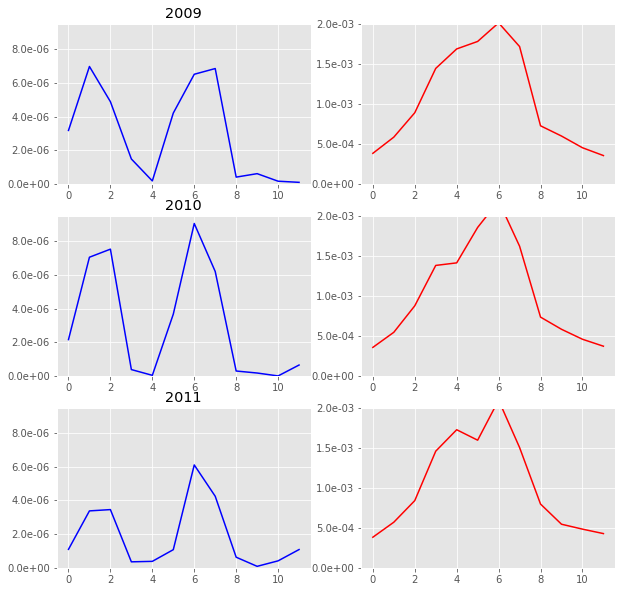

In [200]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
    iax[0].set_ylim([0, 9.5e-6])
    iax[1].set_ylim([0, 2.0e-3])
plt.show()

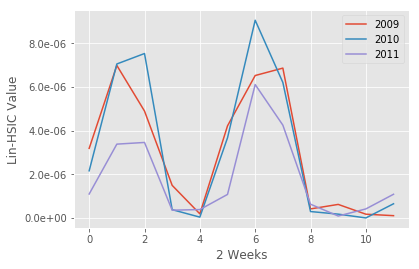

In [201]:
fig, ax = plt.subplots()

ax.plot(lhsic_times['2009'], label='2009')
ax.plot(lhsic_times['2010'], label='2010')
ax.plot(lhsic_times['2011'], label='2011')

ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

#### Russia

In [202]:
%%time
years = ['2009', '2010', '2011']
lhsic_times_r = dict()
lhsic_mods_r = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(str(iyear), str(iyear))).resample(time='2W').mean()
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    lhsic_times_r[iyear] = list()
    lhsic_mods_r[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'linear'
        subsample = 1000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods_r[iyear].append(lhsic_model.get_mod())
        lhsic_times_r[iyear].append(hsic_val)

2009


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2010


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2011


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 28min 57s, sys: 22min 31s, total: 51min 28s
Wall time: 1min 55s


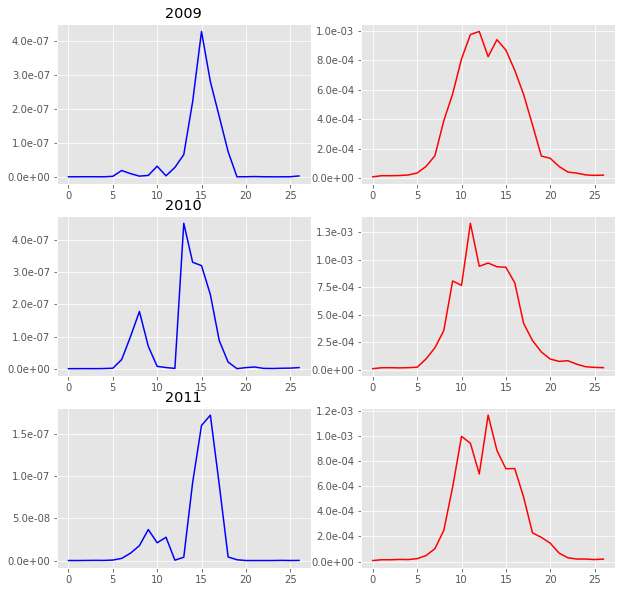

In [203]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times_r[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods_r[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 9.5e-6])
#     iax[1].set_ylim([0, 2.0e-3])
plt.show()

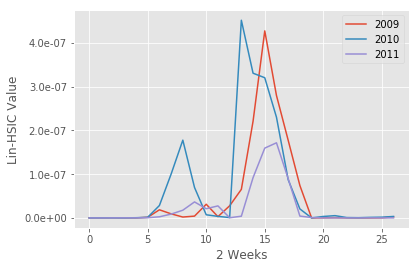

In [204]:
fig, ax = plt.subplots()

ax.plot(lhsic_times_r['2009'], label='2009')
ax.plot(lhsic_times_r['2010'], label='2010')
ax.plot(lhsic_times_r['2011'], label='2011')

ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

## Experiment II - RBF HSIC

In [205]:
%%time
years = ['2009', '2010', '2011']
lhsic_times = dict()
lhsic_mods = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset.sel(time=slice(str(iyear), str(iyear))).resample(time='1MS').mean()
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    lhsic_times[iyear] = list()
    lhsic_mods[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'rbf'
        subsample = 1000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        lhsic_mods[iyear].append(lhsic_model.get_mod())
        lhsic_times[iyear].append(hsic_val)


2009


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2010


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2011


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 19min 42s, sys: 17min 46s, total: 37min 29s
Wall time: 1min 23s


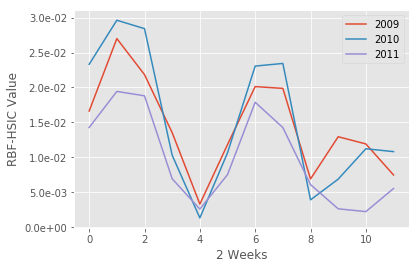

In [206]:
fig, ax = plt.subplots()

ax.plot(lhsic_times['2009'], label='2009')
ax.plot(lhsic_times['2010'], label='2010')
ax.plot(lhsic_times['2011'], label='2011')

ax.set_ylabel('RBF-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

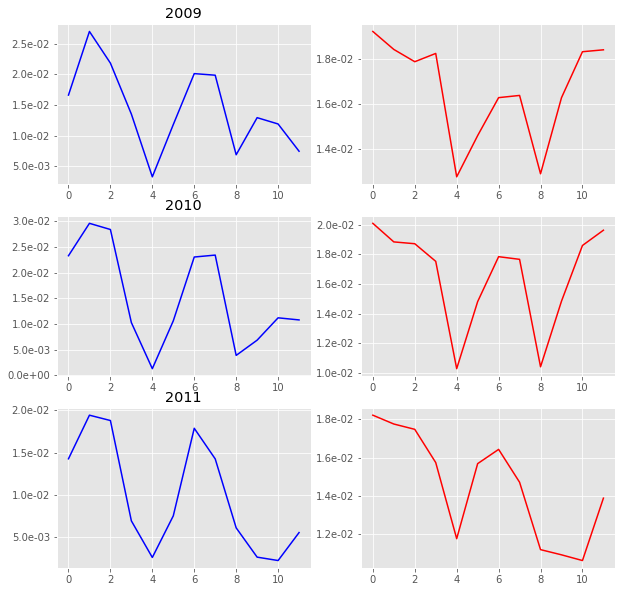

In [207]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 9.5e-6])
#     iax[1].set_ylim([0, 2.0e-3])
plt.show()

### Russia

In [211]:
%%time
years = ['2009', '2010', '2011']
rbfhsic_times_r = dict()
rbfhsic_mods_r = dict()
for iyear in years:
    print(iyear)
    # Subset region (monthly time cycle)
    subset = xr_dataset_r.sel(time=slice(str(iyear), str(iyear))).resample(time='2W').mean()
    dates = subset.time.data

    subsample = 4000
    normalize = True
    variables = [
        'gross_primary_productivity',
        'root_moisture',
    ]

    # Initialize Feature-Getter Class
    data_features = GetXYData(
        subsample=subsample,
        normalize=normalize,
        variables=variables,
    )

    X, Y, lat, lon = data_features.set_XY(subset)
    
    rbfhsic_times_r[iyear] = list()
    rbfhsic_mods_r[iyear] = list()
    for iteration, idate in enumerate(dates):

        model = 'rbf'
        subsample = 4000

        lhsic_model = HSICDependence(
            model=model,
            subsample=subsample
        )

        # Fit HSIC model to data
        lhsic_model.fit_model(X[:,iteration][:, None] , Y[:, iteration][:, None])
        hsic_val = lhsic_model.get_hsic()
        rbfhsic_mods_r[iyear].append(lhsic_model.get_mod())
        rbfhsic_times_r[iyear].append(hsic_val)

2009


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2010


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2011


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


CPU times: user 46min 25s, sys: 38min 17s, total: 1h 24min 42s
Wall time: 3min 13s


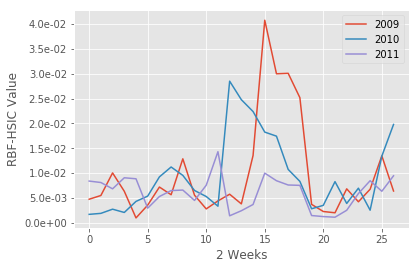

In [209]:
fig, ax = plt.subplots()

ax.plot(lhsic_times_r['2009'], label='2009')
ax.plot(lhsic_times_r['2010'], label='2010')
ax.plot(lhsic_times_r['2011'], label='2011')

ax.set_ylabel('RBF-HSIC Value')
ax.set_xlabel('2 Weeks')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
ax.grid(True)
ax.legend()
plt.show()

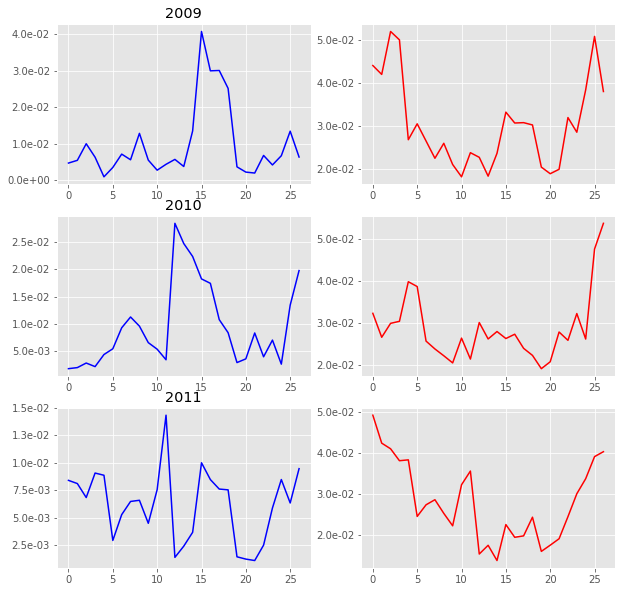

In [210]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for iax, iyear in zip(ax, years):
    iax[0].plot(lhsic_times_r[iyear], label='HSIC', color='blue')
    iax[1].plot(np.array(lhsic_mods_r[iyear]).squeeze().mean(axis=1), label=r'||$\triangledown$HSIC||', color='r')
    iax[0].set_title(iyear)
    
    # Set Tick Params
    iax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    iax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
    
    # Set YLims
#     iax[0].set_ylim([0, 9.5e-6])
#     iax[1].set_ylim([0, 2.0e-3])
plt.show()

## Experiment I - Linear HSIC 

In [33]:
%%time
subsample = 1000
normalize = True
variables = [
    'gross_primary_productivity',
    'root_moisture',
]

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize,
    variables=variables,
)

# Extract variables and coordiantes
subset = xr_dataset.sel(time=slice(str(2010), str(2010))).resample(time='1MS').mean()
dates = xr_dataset.time.data
X, Y, lat, lon = data_features.set_XY(subseet)

TypeError: set_XY() missing 1 required positional argument: 'xr_data'

In [29]:
X.shape

(10000, 12)

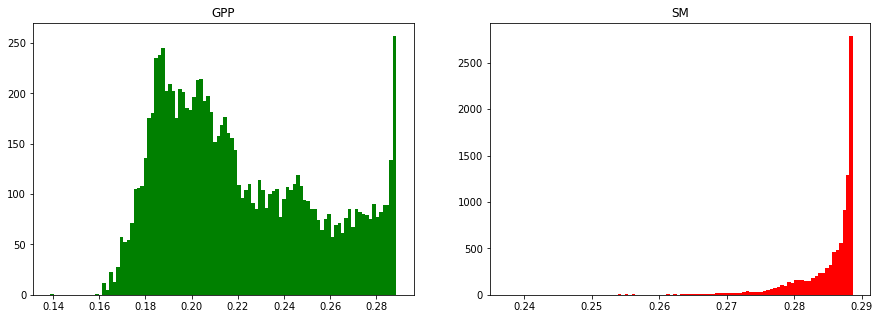

In [30]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [31]:
hsic_times = list()


In [32]:
for itime in range(X.shape[1]):
    
    model = 'linear'
    subsample = 1000

    lhsic_model = HSICDependence(
        model=model,
        subsample=subsample
    )

    # Fit HSIC model to data
    lhsic_model.fit_model(X[:,itime][:, None] , Y[:, itime][:, None])
    hsic_val = lhsic_model.get_hsic()
    hsic_times.append(hsic_val)
    print(hsic_val)

2.0985794328710917e-06
6.430891433821638e-06
7.034077064377727e-06
3.2700826923088195e-07
1.9161674287686338e-08
3.418579219780041e-06
9.137667431546983e-06
6.246483283988974e-06
2.539341034298691e-07
1.607075377130979e-07
1.0102022421726106e-08
7.140620835453669e-07


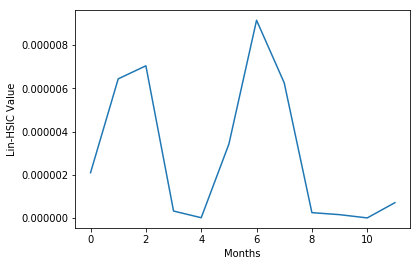

In [36]:
fig, ax = plt.subplots()

ax.plot(hsic_times)
ax.set_ylabel('Lin-HSIC Value')
ax.set_xlabel('Months')
plt.show()

In [52]:
%%time

model = 'linear'
subsample = 1000

lhsic_model = HSICDependence(
    model=model,
    subsample=subsample
)

# Fit HSIC model to data
lhsic_model.fit_model(X, Y)

CPU times: user 2min 31s, sys: 20.6 s, total: 2min 52s
Wall time: 8.06 s


In [53]:
print(f"HSIC: {lhsic_model.get_hsic():.4f}")

HSIC: 0.0004


In [58]:
%%time
derX['lhsic'], derY['lhsic'] = lhsic_model.get_derivative()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 296 µs


In [59]:
%%time
mod_sens['lhsic'] = lhsic_model.get_mod()
ang_sens['lhsic'] = lhsic_model.get_angle()

CPU times: user 97.7 ms, sys: 3.01 ms, total: 101 ms
Wall time: 99.8 ms


In [60]:
print(X.shape, ang_sens['lhsic'].shape)

(10000, 138) (10000, 138)


### Scatter Plot - Normalized Data

In [ ]:
plot_sens_scatters(X, Y, mod_sens['lhsic'], ang_sens['lhsic'], year=year, model='lhsic', mean=True, normed=True)

### Convert Data to Xarray

In [27]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['lhsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


## Maps

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


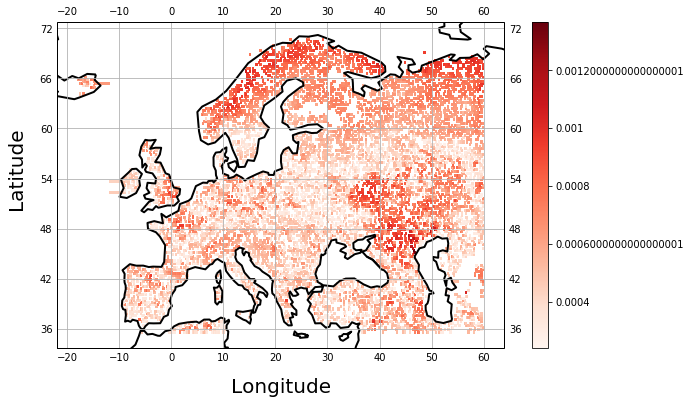

In [28]:
plot_sens_mod(mod_data.sens, year, model='lhsic', mean=True)

<Figure size 720x720 with 0 Axes>

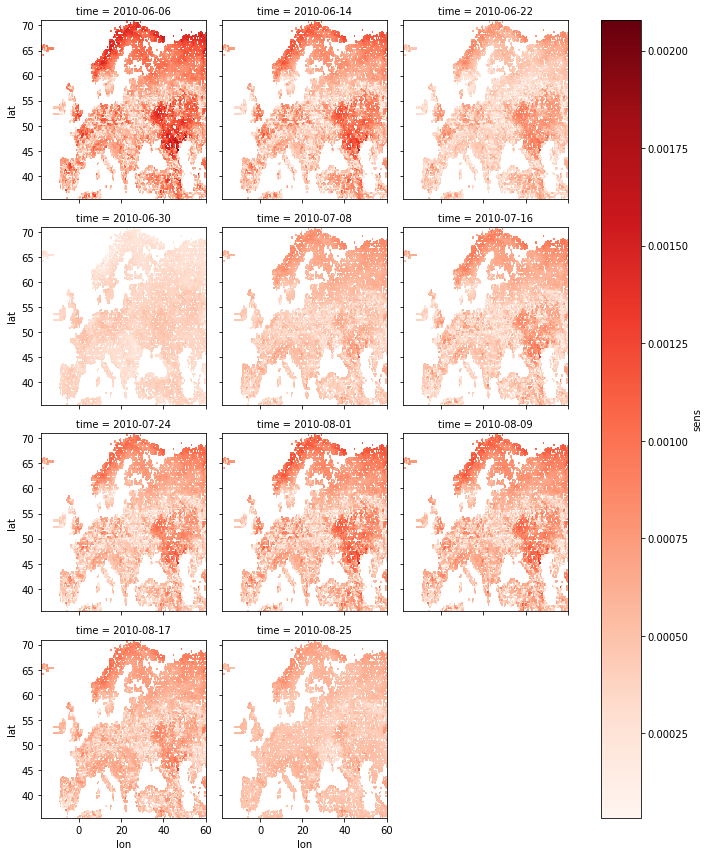

In [29]:
plot_sens_mod(mod_data.sens, year, model='lhsic', mean=False)

### Angle

In [30]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['lhsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['lhsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(10000, 11) (10000, 11)
CPU times: user 1.23 s, sys: 35.2 ms, total: 1.26 s
Wall time: 1.26 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


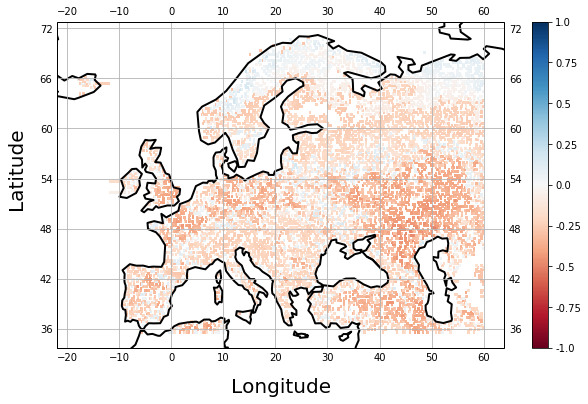

In [32]:
plot_sens_angle(ang_data.sens, year, model='lhsic', mean=True)

<Figure size 720x720 with 0 Axes>

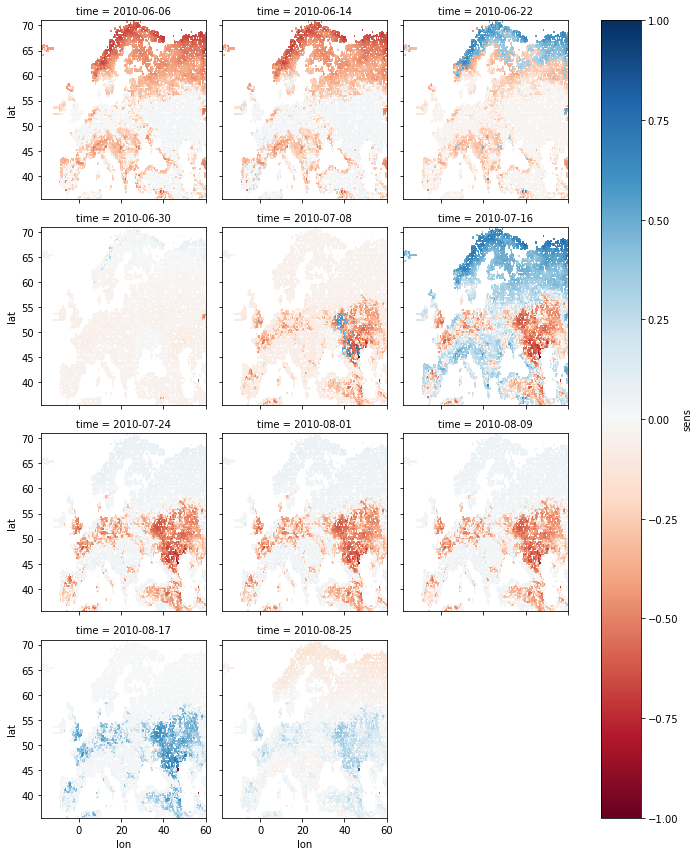

In [34]:
plot_sens_angle(ang_data.sens, year, model='lhsic', mean=False)

## Experiment II - HSIC (RBF Kernel)

In [55]:
subsample = 10000
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


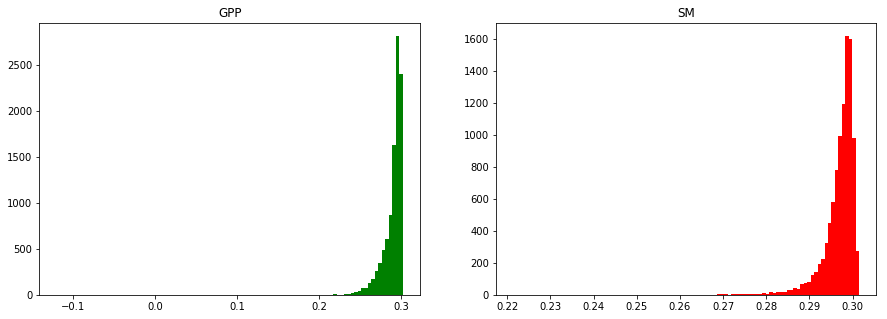

In [56]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [57]:
%%time

model = 'rbf'
subsample = 1000

hsic_model = HSICDependence(
    model=model,
    subsample=subsample,
)

# Fit HSIC model to data
hsic_model.fit_model(X, Y)

CPU times: user 2min 26s, sys: 32.4 s, total: 2min 58s
Wall time: 9.38 s


In [59]:
print(f"HSIC: {hsic_model.get_hsic():.4f}")

HSIC: 0.0065


In [58]:
derX['hsic'], derY['hsic'] = hsic_model.get_derivative()

In [60]:
mod_sens['hsic'] = hsic_model.get_mod()
ang_sens['hsic'] = hsic_model.get_angle()

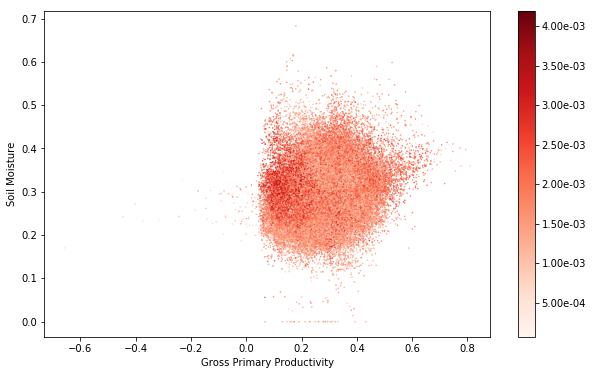

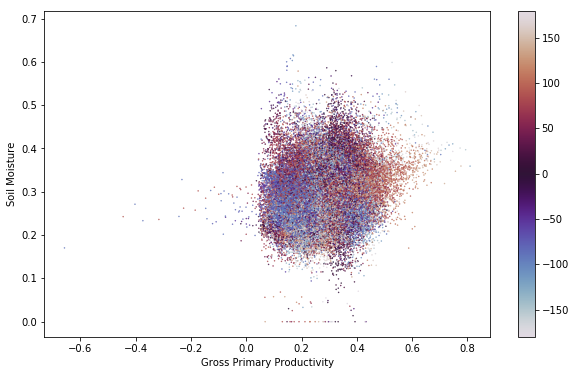

In [61]:
plot_sens_scatters(X, Y, mod_sens['hsic'], ang_sens['hsic'], year=year, model='hsic', mean=False, normed=True)

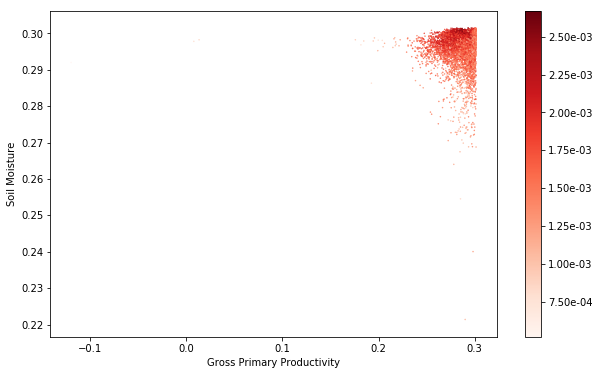

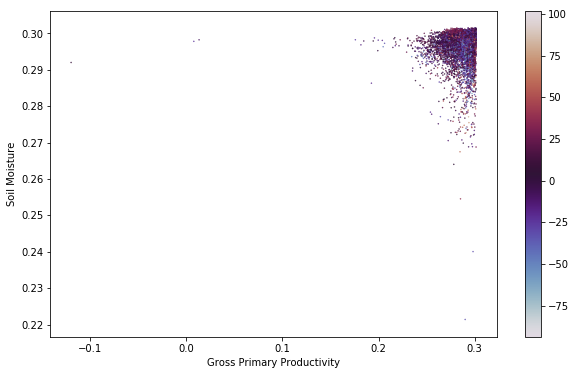

In [62]:
plot_sens_scatters(X.mean(axis=1), Y.mean(axis=1), mod_sens['hsic'].mean(axis=1), ang_sens['hsic'].mean(axis=1), year=year, model='hsic', mean=True, normed=True)

In [63]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['hsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


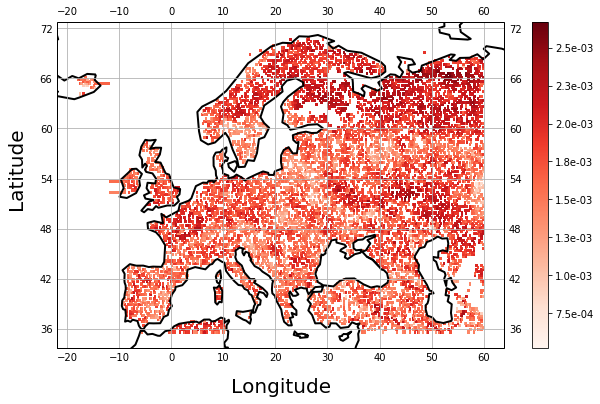

In [64]:
plot_sens_mod(mod_data.sens, year, model='hsic', mean=True)

<Figure size 720x720 with 0 Axes>

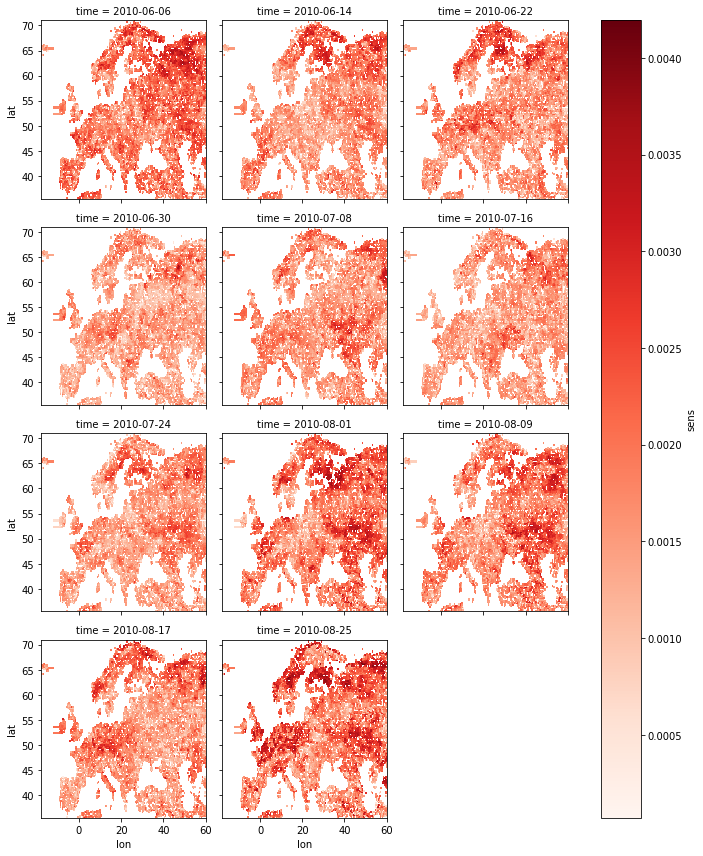

In [65]:
plot_sens_mod(mod_data.sens, year, model='hsic', mean=False)

In [66]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['hsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['hsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(10000, 11) (10000, 11)
CPU times: user 1.15 s, sys: 24.9 ms, total: 1.17 s
Wall time: 1.17 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


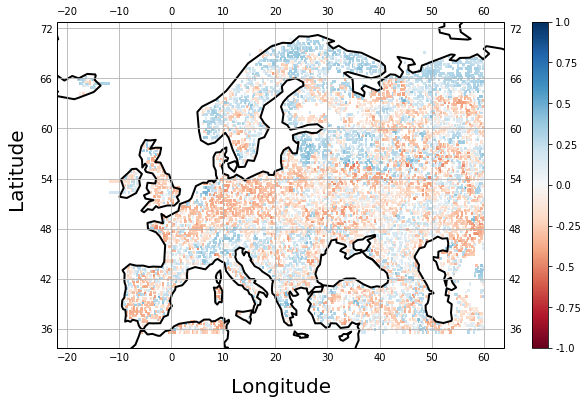

In [67]:
plot_sens_angle(ang_data.sens, year, model='hsic', mean=True)

<Figure size 720x720 with 0 Axes>

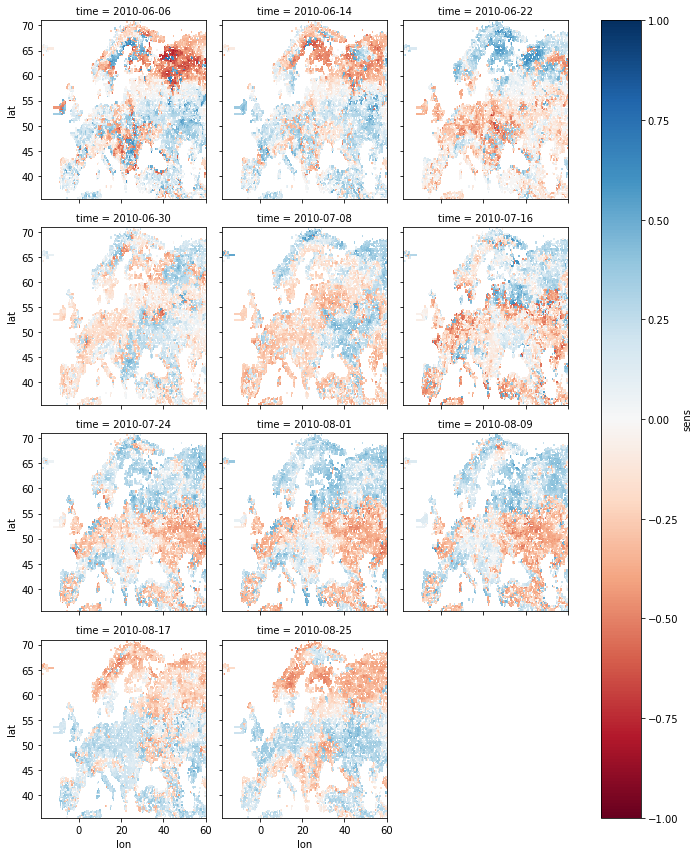

In [68]:
plot_sens_angle(ang_data.sens, year, model='hsic', mean=False)

## Experiment III - Randomized HSIC

In [35]:
subsample = None
normalize = True

# Initialize Feature-Getter Class
data_features = GetXYData(
    subsample=subsample,
    normalize=normalize
)

# Extract variables and coordiantes
X, Y, lat, lon = data_features.set_XY(subset)

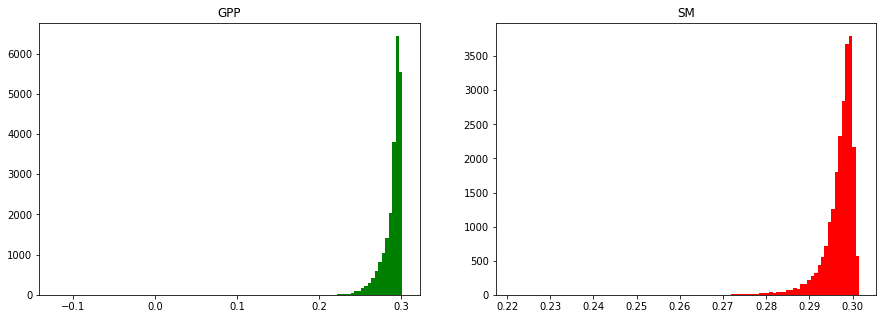

In [36]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)

ax[0].hist(X.mean(axis=1), bins=100, color='green')
# ax[0].hist(X_sub.mean(axis=1), bins=100, color='green')
ax[0].set_title('GPP')

ax[1].hist(Y.mean(axis=1), bins=100, color='red')
# ax[1].hist(Y_sub.mean(axis=1), bins=100, color='red')
ax[1].set_title('SM')

plt.show()

In [37]:
%%time

model = 'rff'
subsample = 1000
n_features = 2000

rhsic_model = HSICDependence(
    model=model,
    subsample=subsample,
    n_features=n_features
)

# Fit HSIC model to data
rhsic_model.fit_model(X, Y)

CPU times: user 53.1 s, sys: 45.9 s, total: 1min 38s
Wall time: 23.1 s


In [38]:
print(f"RHSIC: {rhsic_model.get_hsic():.4f}")

RHSIC: 0.0066


In [39]:
%%time
derX['rhsic'], derY['rhsic'] = rhsic_model.get_derivative()

CPU times: user 15min 32s, sys: 17min 48s, total: 33min 21s
Wall time: 1min 31s


In [40]:
%%time
mod_sens['rhsic'] = rhsic_model.get_mod()
ang_sens['rhsic'] = rhsic_model.get_angle()

CPU times: user 18.3 ms, sys: 6.15 ms, total: 24.4 ms
Wall time: 24.1 ms


### Scatter Plot - Normalized Data

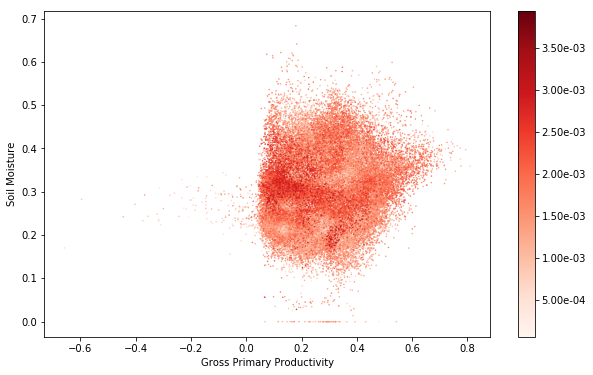

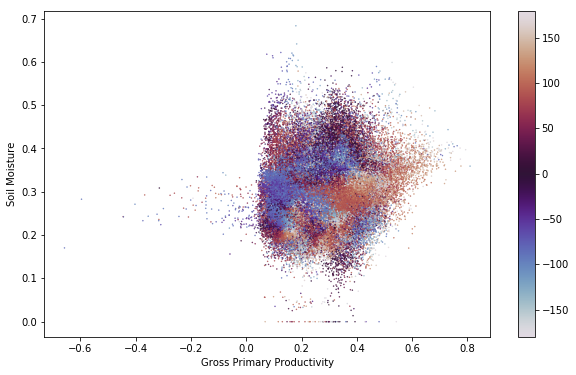

In [41]:
plot_sens_scatters(X, Y, mod_sens['rhsic'], ang_sens['rhsic'], year=year, model='rhsic', mean=False, normed=True)

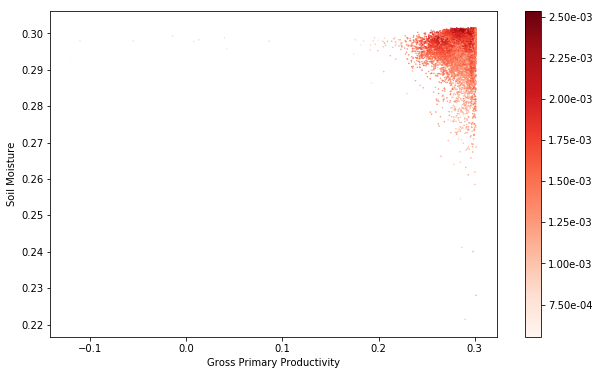

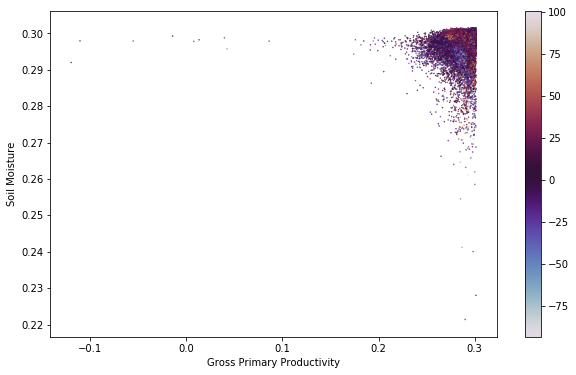

In [42]:
plot_sens_scatters(X.mean(axis=1), Y.mean(axis=1), mod_sens['rhsic'].mean(axis=1), ang_sens['rhsic'].mean(axis=1), year=year, model='rhsic', mean=True, normed=True)

In [43]:
mod_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': mod_sens['rhsic'][:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    mod_data.append(vis_xr)

mod_data = xr.concat(mod_data, dim='time')


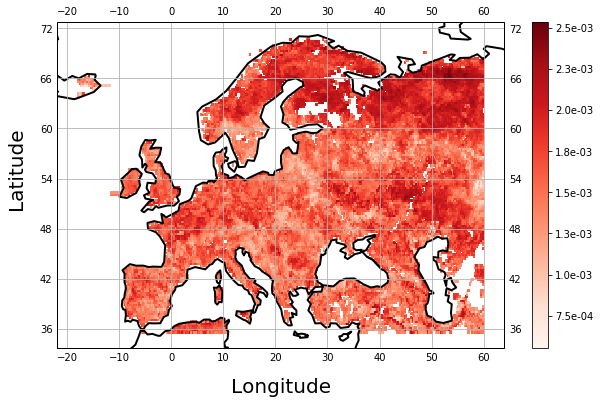

In [50]:
plot_sens_mod(mod_data.sens, year, model='rhsic', mean=True)

<Figure size 720x720 with 0 Axes>

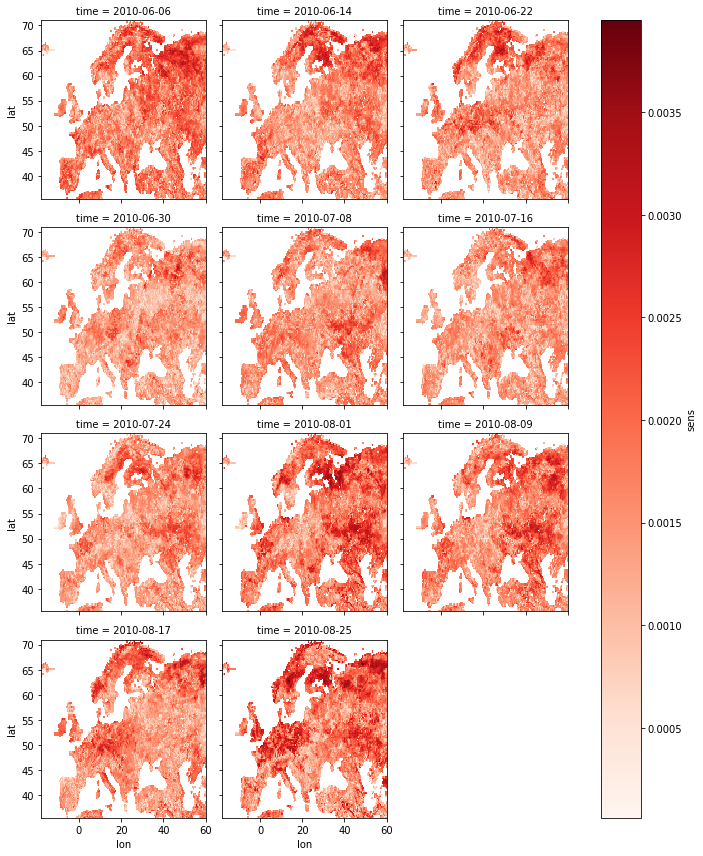

In [51]:
plot_sens_mod(mod_data.sens, year, model='rhsic', mean=False)

In [52]:
%%time

test_mod = MinMaxScaler().fit_transform(mod_sens['rhsic'])
test_ang = MinMaxScaler(feature_range=(-1, 1)).fit_transform(ang_sens['rhsic'])
print(test_mod.shape, test_ang.shape)
test_data = test_mod * test_ang

# print(test_data.shape)
# data = test_data.mean(axis=1) / np.abs(test_data).max()
# data = np.sqrt( np.abs(data)) * np.sign(data) 


ang_data = list()

for iteration, itimes in enumerate(dates):
    
    vis_df = pd.DataFrame({
        'lat': lat,
        'lon': lon,
        'sens': test_data[:, iteration],
    })
    
    vis_xr = create_xarray(vis_df, variable='sens')
    vis_xr.coords['time'] = [itimes]
#     vis_xr = vis_xr.expand_dims(dim=['time'])
#     vis_xr = vis_xr.assign_coords(time=itimes)
#     print(vis_xr)
    ang_data.append(vis_xr)

ang_data = xr.concat(ang_data, dim='time')

(23090, 11) (23090, 11)
CPU times: user 1.21 s, sys: 42.2 ms, total: 1.26 s
Wall time: 1.25 s


/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


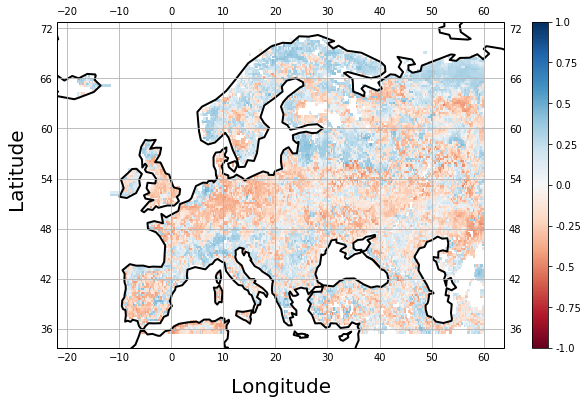

In [53]:
plot_sens_angle(ang_data.sens, year, model='rhsic', mean=True)

<Figure size 720x720 with 0 Axes>

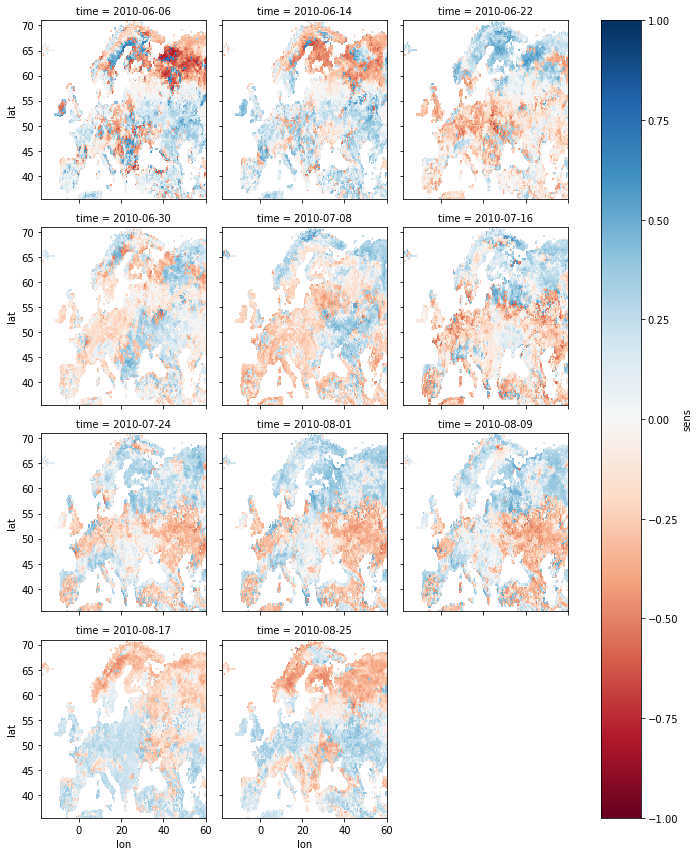

In [54]:
plot_sens_angle(ang_data.sens, year, model='rhsic', mean=False)

### Sensitivity

Converting Cartesian to Polar Coordinates

* Modulus: $r = \sqrt{x^2 + y^2}$
* Angle: $\theta = \arctan{\frac{y}{x}}$

In [271]:
%%time

# Calculate the Modulus of the Derivatives
mod_sens['rhsic'] = np.sqrt(np.abs(derX['rhsic']) + np.abs(derY['rhsic']))

# Calculate the Direction of the Derivatives
ang_sens['rhsic'] = np.arctan2( 
    np.abs(derY['rhsic']), 
    np.abs(derX['rhsic']))

# Convert radians to degrees
ang_sens['rhsic'] = np.rad2deg(ang_sens['rhsic'])

CPU times: user 9.88 ms, sys: 2.84 ms, total: 12.7 ms
Wall time: 12.1 ms
